# Climate information by County

Base URL is: `https://www.ncdc.noaa.gov/cag/county/time-series/{noaa_code}-{noaa_var}-{time_scale}-{month}-{y_start}-{y_end}.json`

Where:

`noaa_code` = A county identification code

`noaa_var` = The variable to retrieve, one of: `pcp`, `tmax`, `tavg`, `tmin`

`time_scale` = Period over which to retrieve data, `{x}`, `ytd`, `ann`, `all`. `x` is number of months `[1..12,18,24,36,48,60]`

`month` = Month of year (1 = january)

`y_start` = Year for begining of data

`y_end` = Year for end of data retrieval

`pcp` is precipitation in inches

`tmin`, `tmax`, and `tavg` are minimum, maximum, and average daily temperatures for the month



In [5]:
import requests
import json
import csv

def getNoaaCode(state, county):
    with open("data/NOAA_county_codes.csv") as csv_file:
        reader = csv.reader(csv_file)
        state = state.strip().lower()
        county = county.strip().lower()
        for row in reader:
            if row[0].strip().lower() == state:
                if row[1].strip().lower().startswith(county):
                    return row[2]
    return None
        

run_params = {"state":"NM",
              "county":"Bernalillo",
              "variable":"Tmax",
              "units":"",
              "start_year":1895,
              "end_year":2019,
             }

vars = {"tmin":"tmin",
        "tmax":"tmax",
        "tavg":"tavg",
        "precipitation":"pcp"
       }
noaa_code = getNoaaCode(run_params["state"], run_params["county"])
noaa_var = vars[run_params["variable"].lower()]
if noaa_var == "pcp":
    run_params["units"] = "inches"
else:
    run_params["units"] = "°F"

url = (f"https://www.ncdc.noaa.gov/cag/county/time-series/{noaa_code}-{noaa_var}-all-2-"
       f"{run_params['start_year']}-{run_params['end_year']}.json"
       f"?base_prd=true&begbaseyear={run_params['start_year']}&endbaseyear={run_params['end_year']}")
print("URL = " + url)
data_text = requests.get(url).text
src_data = json.loads(data_text)
#print(json.dumps(data, indent=2))

URL = https://www.ncdc.noaa.gov/cag/county/time-series/NM-001-tmax-all-2-1895-2019.json?base_prd=true&begbaseyear=1895&endbaseyear=2019


In [6]:
from datetime import datetime
month_data = [
]
year_data = {"time":[], "variable":[], "anomaly":[]}
for i in range(0,12):
    month_data.append({"month":i+1, "time":[], "variable":[], "anomaly":[]})
for k in src_data["data"]:
    entry = src_data["data"][k]
    y = float(k[0:4])
    m = int(k[4:6])
    t = y + m/12.0
    variable = float(entry["value"])
    anomaly = float(entry["anomaly"])
    year_data["time"].append(t)
    year_data["variable"].append(variable)
    year_data["anomaly"].append(anomaly)
    month_data[m-1]["time"].append(t)
    month_data[m-1]["variable"].append(variable)
    month_data[m-1]["anomaly"].append(anomaly)


In [7]:
# following from: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
#
import numpy as np
import pylab as pl
from numpy import fft

pl.rcParams["figure.figsize"] = (16,4)

def fourierExtrapolation(x, n_predict, n_harm=10):
    """
    x = list of evenly spaced values
    n_predict = number of future intervals to predict
    n_harm = number of harmonics to use
    """
    n = x.size
    t = np.arange(0.0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
    # sort indexes by amplitude, and reverse to take the highest amplitude
    #indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    #indexes.reverse()
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

def test():
    x = np.array([669, 592, 664, 1005, 699, 401, 646, 472, 598, 681, 1126, 1260, 562, 491, 714, 530, 521, 687, 776, 802, 499, 536, 871, 801, 965, 768, 381, 497, 458, 699, 549, 427, 358, 219, 635, 756, 775, 969, 598, 630, 649, 722, 835, 812, 724, 966, 778, 584, 697, 737, 777, 1059, 1218, 848, 713, 884, 879, 1056, 1273, 1848, 780, 1206, 1404, 1444, 1412, 1493, 1576, 1178, 836, 1087, 1101, 1082, 775, 698, 620, 651, 731, 906, 958, 1039, 1105, 620, 576, 707, 888, 1052, 1072, 1357, 768, 986, 816, 889, 973, 983, 1351, 1266, 1053, 1879, 2085, 2419, 1880, 2045, 2212, 1491, 1378, 1524, 1231, 1577, 2459, 1848, 1506, 1589, 1386, 1111, 1180, 1075, 1595, 1309, 2092, 1846, 2321, 2036, 3587, 1637, 1416, 1432, 1110, 1135, 1233, 1439, 894, 628, 967, 1176, 1069, 1193, 1771, 1199, 888, 1155, 1254, 1403, 1502, 1692, 1187, 1110, 1382, 1808, 2039, 1810, 1819, 1408, 803, 1568, 1227, 1270, 1268, 1535, 873, 1006, 1328, 1733, 1352, 1906, 2029, 1734, 1314, 1810, 1540, 1958, 1420, 1530, 1126, 721, 771, 874, 997, 1186, 1415, 973, 1146, 1147, 1079, 3854, 3407, 2257, 1200, 734, 1051, 1030, 1370, 2422, 1531, 1062, 530, 1030, 1061, 1249, 2080, 2251, 1190, 756, 1161, 1053, 1063, 932, 1604, 1130, 744, 930, 948, 1107, 1161, 1194, 1366, 1155, 785, 602, 903, 1142, 1410, 1256, 742, 985, 1037, 1067, 1196, 1412, 1127, 779, 911, 989, 946, 888, 1349, 1124, 761, 994, 1068, 971, 1157, 1558, 1223, 782, 2790, 1835, 1444, 1098, 1399, 1255, 950, 1110, 1345, 1224, 1092, 1446, 1210, 1122, 1259, 1181, 1035, 1325, 1481, 1278, 769, 911, 876, 877, 950, 1383, 980, 705, 888, 877, 638, 1065, 1142, 1090, 1316, 1270, 1048, 1256, 1009, 1175, 1176, 870, 856, 860])
    n_predict = 100
    extrapolation = fourierExtrapolation(x, n_predict)
    pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
    pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
    pl.legend()
    pl.show()

#test()



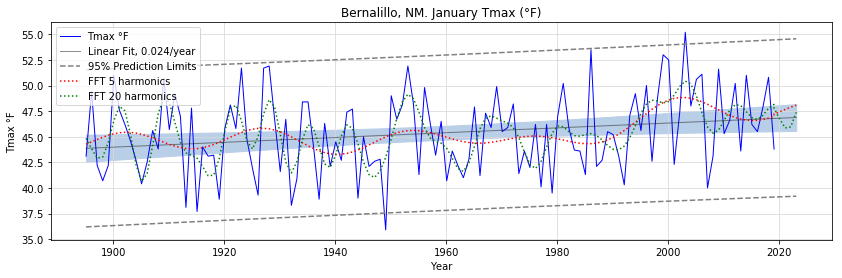

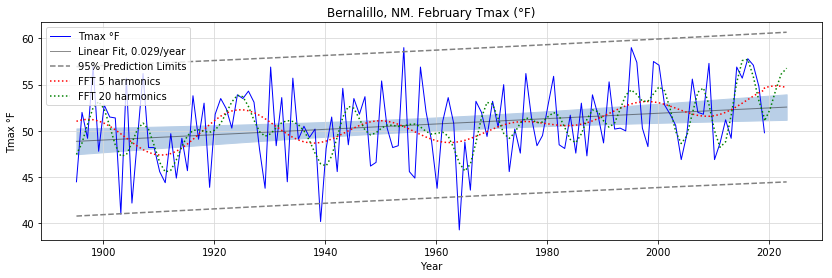

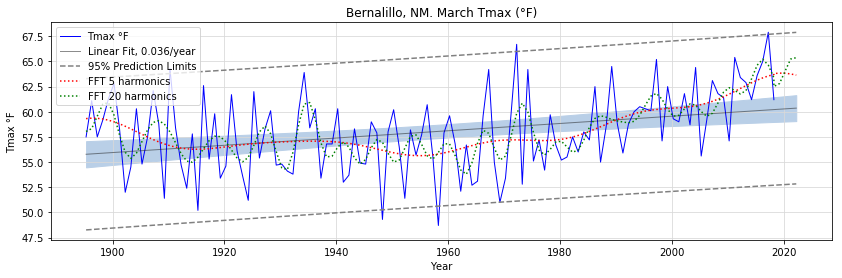

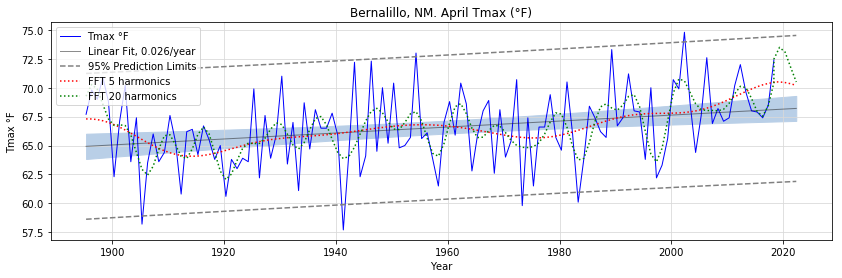

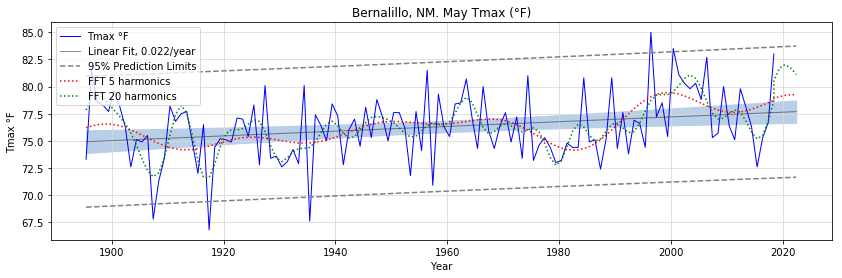

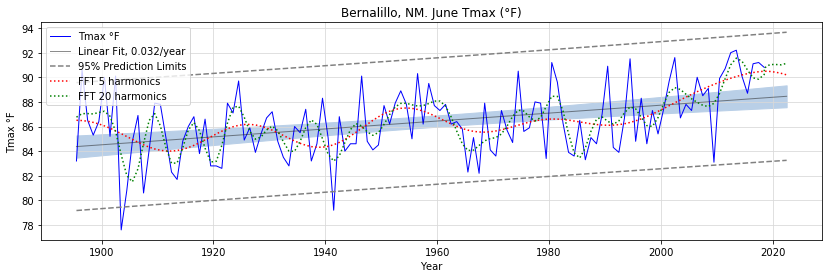

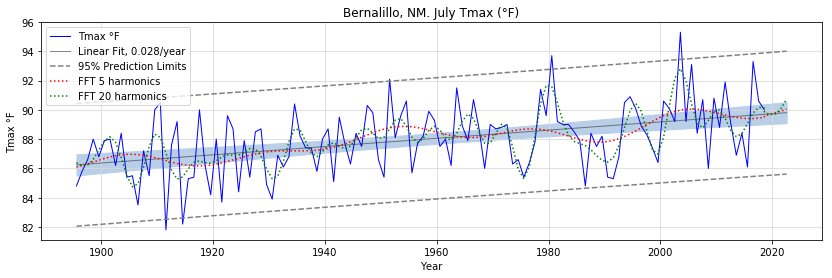

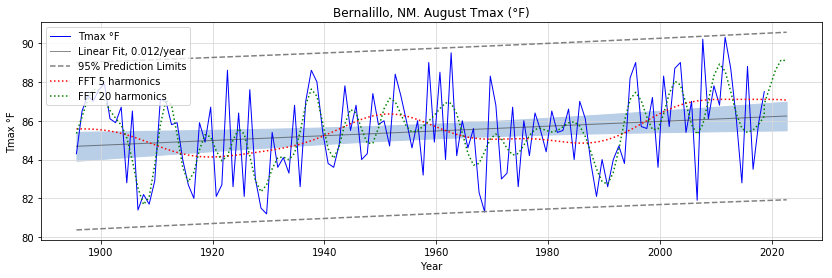

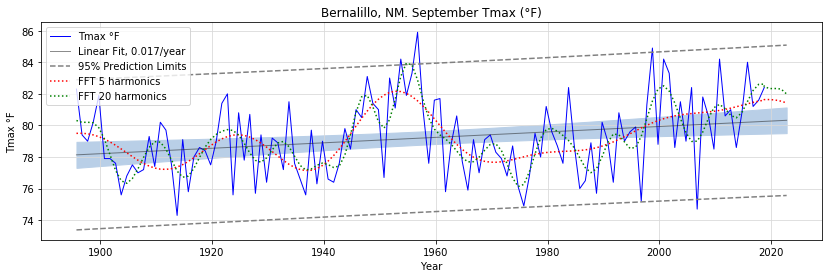

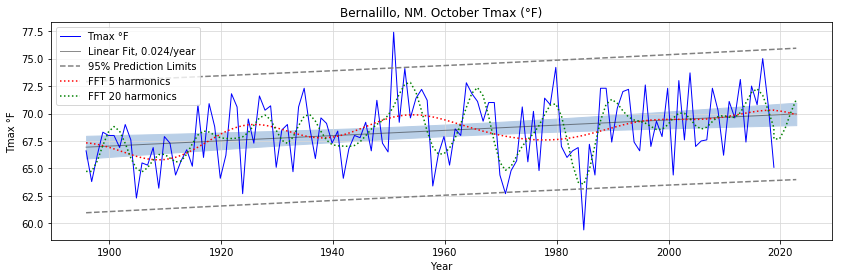

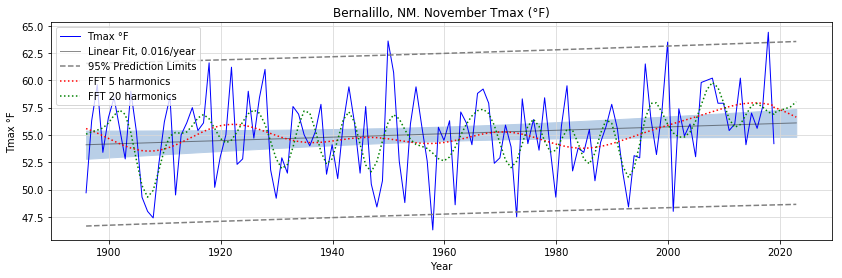

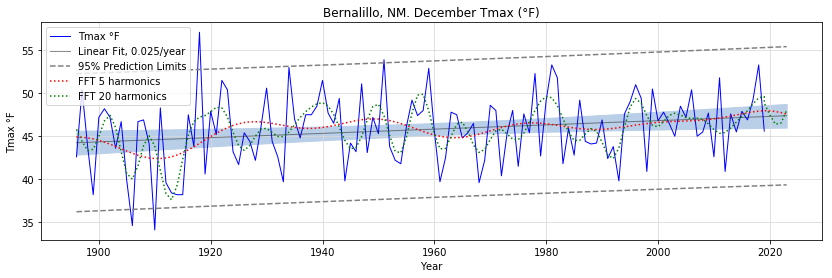

In [8]:
import scipy as sp
import scipy.stats as stats

# From: https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1]: M. Duarte.  "Curve fitting," JUpyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()
    ci = t*s_err*np.sqrt(1/n + (x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))
    ax.fill_between(x2, y2+ci, y2-ci, color="#b9cfe7", edgecolor="")
    return ax


def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()
    bootindex = sp.random.randint
    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid)-1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, sp.polyval(pc, xs), "b-", linewidth=2, alpha=3.0/float(nboot))
    return ax

# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

n_predict = run_params.get("n_predict", 5)
n_harm_1 = run_params.get("n_harm_1", 5)
n_harm_2 = run_params.get("n_harm_2", 20)
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
for month in range(0,12):
    dates = month_data[month]["time"].copy()
    dates_ext = month_data[month]["time"].copy()
    values = np.array(month_data[month]["variable"].copy())

    delta = dates[1] - dates[0]
    spos = len(dates)
    sval = dates[spos-1]
    for i in range(0, n_predict):
        dates_ext.append(sval + (i*delta))
    dates = np.array(dates)
    dates_ext = np.array(dates_ext)

    extrapolation = fourierExtrapolation(values, n_predict, n_harm=n_harm_1)
    extrapolation2 = fourierExtrapolation(values, n_predict, n_harm=n_harm_2)

    p, cov = np.polyfit(dates, values, 1, cov=True)
    y_model = equation(p, dates)
    linear_extrapolation = equation(p, dates_ext)
    n = values.size
    m = p.size
    dof = n - m
    t = stats.t.ppf(0.975, n-m)
    resid = values - y_model
    chi2 = np.sum((resid/y_model)**2)
    chi2_red = chi2/(dof)
    s_err = np.sqrt(np.sum(resid**2)/(dof))
    
    x2 = np.linspace(np.min(dates_ext), np.max(dates_ext), 30)
    y2 = equation(p, x2)
    
    ref = equation([0, y_model[0]], x2)
    
    pl.grid(color="0.85")
    pl.plot(dates, values, "b", label=f"{run_params['variable']} {run_params['units']}", linewidth=1)
    #pl.plot(x2, ref, color="0.3", linestyle=(0, (5, 2)), label="Reference", linewidth=2, alpha=0.5)
    pl.plot(dates_ext, linear_extrapolation, "-", color="0.1", linewidth=1, alpha=0.5, label=f"Linear Fit, {p[0]:.3f}/year")
    plot_ci_manual(t, s_err, n, dates_ext, x2, y2, ax=pl)
    #plot_ci_bootstrap(dates, values, resid, ax=pl)
    
    pi = t*s_err*np.sqrt(1+1/n+(x2-np.mean(dates))**2/np.sum((dates-np.mean(dates))**2))   
    pl.fill_between(x2, y2+pi, y2-pi, color="None", linestyle="--")
    pl.plot(x2, y2-pi, "--", color="0.5", label="95% Prediction Limits")
    pl.plot(x2, y2+pi, "--", color="0.5")       
    pl.plot(dates_ext, extrapolation, ":r", label=f"FFT {n_harm_1} harmonics")
    pl.plot(dates_ext, extrapolation2, ":g", label=f"FFT {n_harm_2} harmonics")
    pl.legend(loc="upper left")
    pl.title(f"{run_params['county']}, {run_params['state']}. {months[month]} {run_params['variable']} ({run_params['units']})")
    pl.xlabel("Year")
    pl.ylabel(f"{run_params['variable']} {run_params['units']}")
    fig = pl.gcf()
    fig.set_size_inches(14,4)
    pl.show()

    
